In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/factors/RTSI.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df['2009-01':'2019'].Close
series = series.resample('14d').last()
series2020 = df['2020':].Close

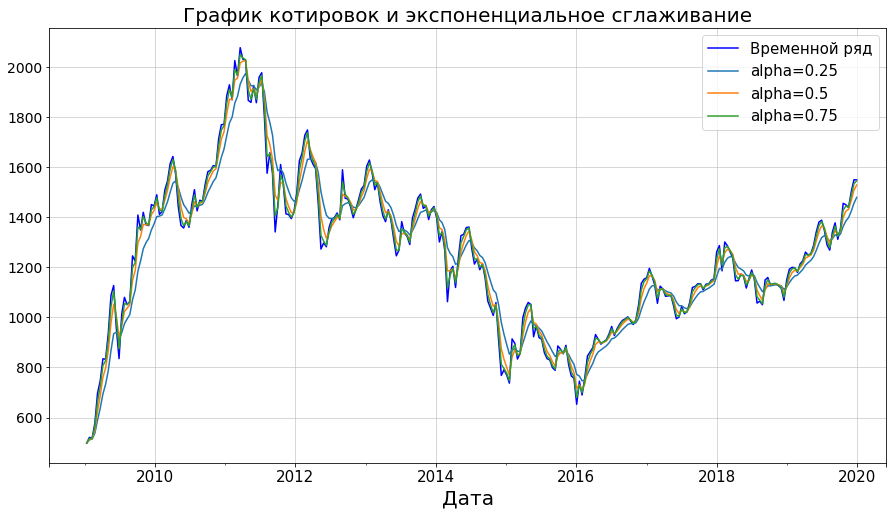

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд')
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

### Тест Фуллера на стационарность ряда

In [4]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


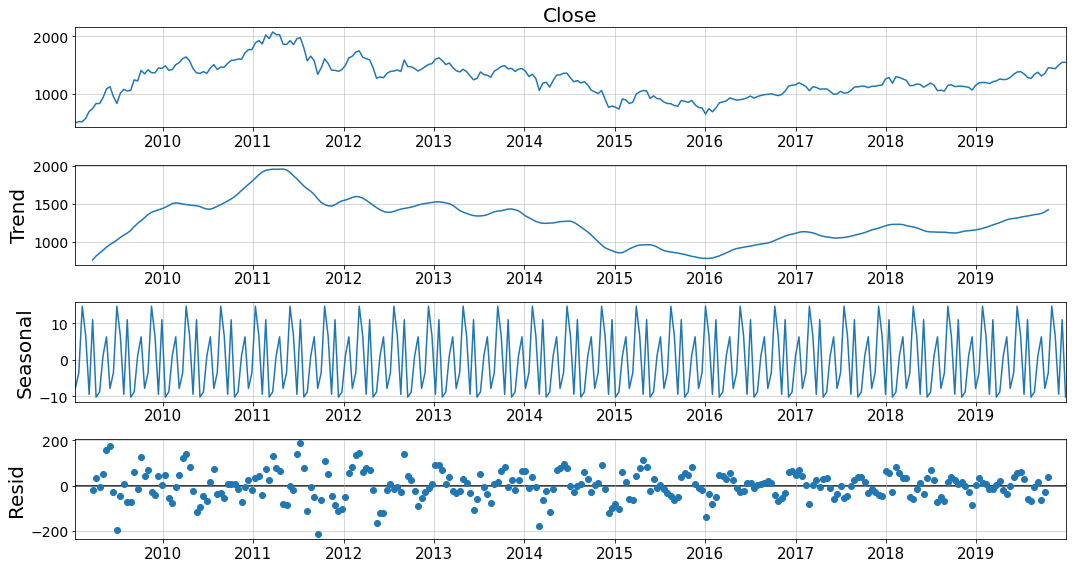

In [5]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

# Тренд 1 + ARMA на остатках

# Составление тренда 

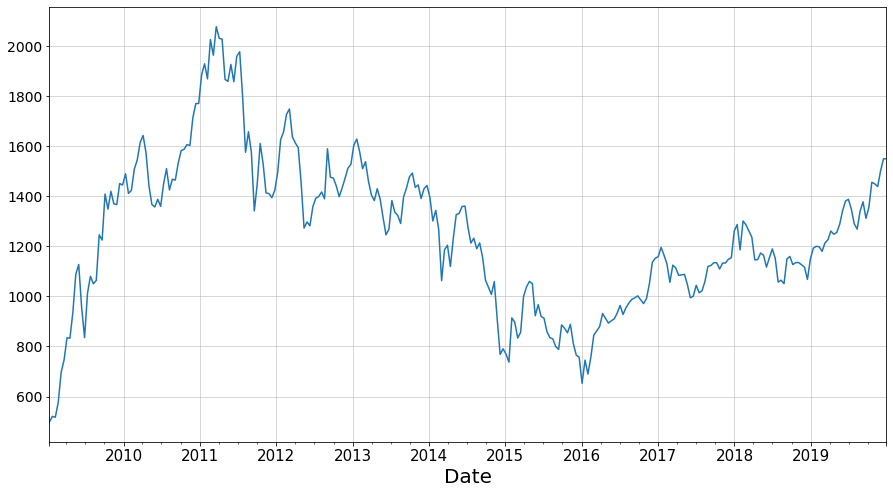

In [6]:
series.plot()

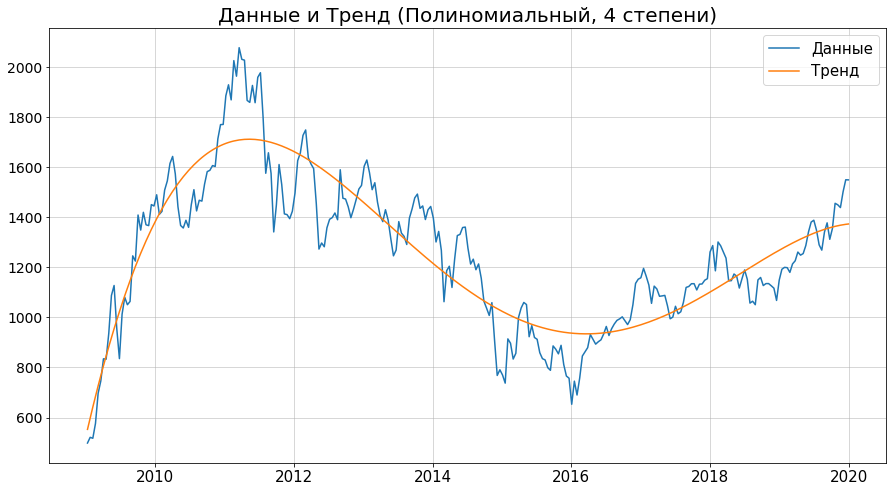

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     295.2
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.78e-99
Time:                        22:32:32   Log-Likelihood:                -1809.5
No. Observations:                 287   AIC:                             3629.
Df Residuals:                     282   BIC:                             3647.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        506.4321     40.261     12.579      0.000     427.182     585.683
x1            46.8926      1.930     24.298      0.000      43.094      50.691
x2            -0.5844      0.027    -21.497      0.000      -0.638      -0.531
x3             0.0025      0.000     17.617      0.000       0.002       0.003
x4         -3.459e-06   2.44e-07    -14.172      0.000   -3.94e-06   -2.98e-06
==============================================================================
Omnibus:                        0.531   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.767   Jarque-Bera (JB):                0.658
Skew:                          -0.051   Prob(JB):                        0.720
Kurtosis:                       2.789   Cond. No.                     1.16e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(1, series.size+1)[:, np.newaxis])
series_trend_fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные и Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = series_trend_fitted_model.fittedvalues
series_remains = series_trend_fitted_model.resid
series_remains_exog = series_trend_fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend()
plt.show()
display(series_trend_fitted_model.summary())


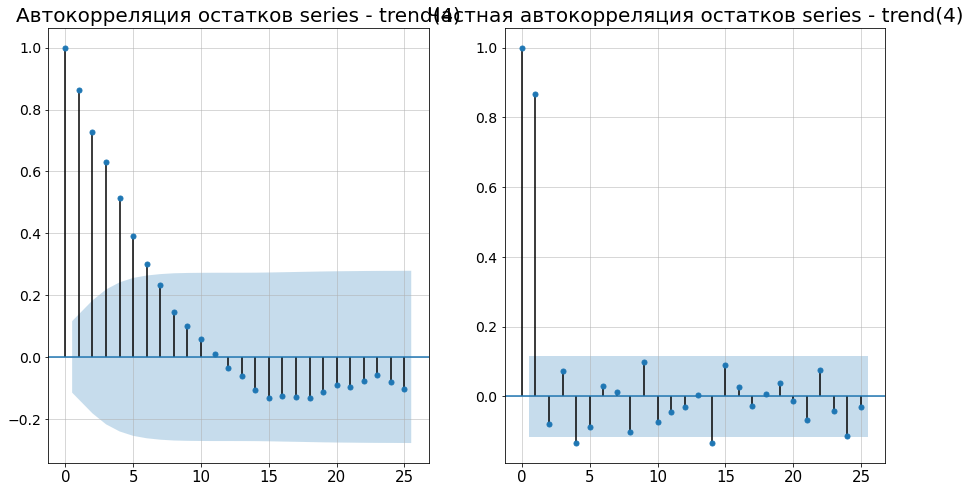

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [9]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  287
Model:                     ARMA(4, 4)   Log Likelihood               -1595.103
Method:                       css-mle   S.D. of innovations             62.215
Date:                Tue, 14 Apr 2020   AIC                           3210.206
Time:                        22:32:35   BIC                           3246.800
Sample:                    01-11-2009   HQIC                          3224.872
                         - 12-29-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5303      3.245      0.163      0.870      -5.831       6.891
ar.L1.y        1.1542      0.060     19.140      0.000       1.036       1.272
ar.L2.y       -0.4953      0.082     -6.054      0.000      -0.656      -0.335
ar.L3.y        1.1381      0.059     19.155      0.000       1.022       1.255
ar.L4.y       -0.8300      0.042    -19.720      0.000      -0.912      -0.748
ma.L1.y       -0.2428      0.085     -2.844      0.004      -0.410      -0.075
ma.L2.y        0.1402      0.048      2.899      0.004       0.045       0.235
ma.L3.y       -0.8960      0.066    -13.582      0.000      -1.025      -0.767
ma.L4.y       -0.0013      0.071     -0.018      0.985      -0.140       0.137
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3766           -0.9573j            1.0287           -0.3096
AR.2           -0.3766           +0.9573j            1.0287            0.3096
AR.3            1.0622           -0.1015j            1.0670           -0.0152
AR.4            1.0622           +0.1015j            1.0670            0.0152
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4216           -0.9685j            1.0563           -0.3153
MA.3           -0.4216           +0.9685j            1.0563            0.3153
MA.4         -694.0691           -0.0000j          694.0691           -0.5000
-----------------------------------------------------------------------------
"""

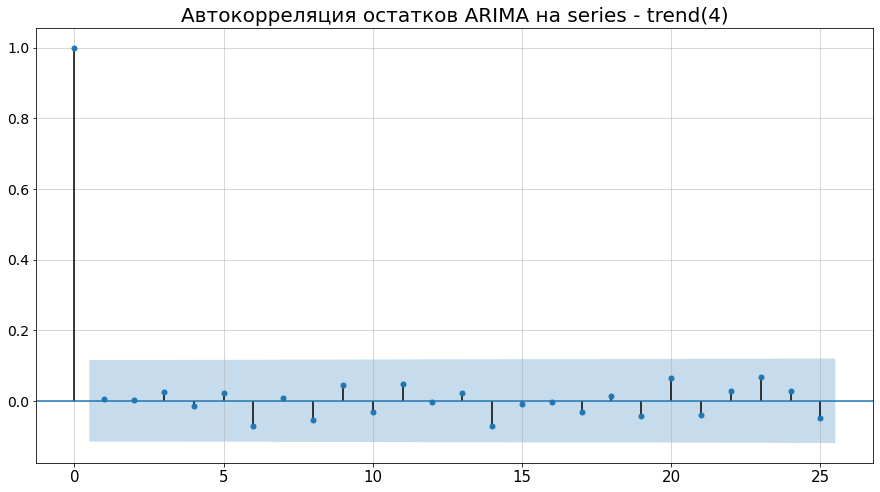

In [10]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

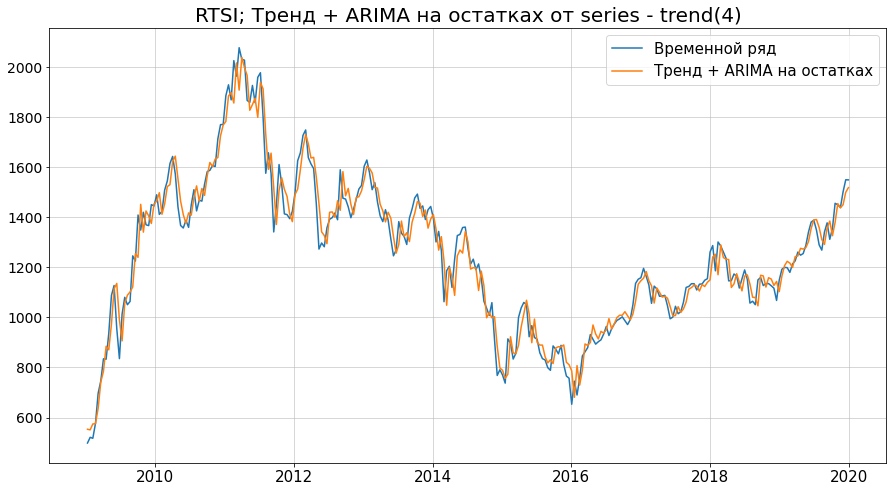

In [11]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('RTSI; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа (остатков от тренда)
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции
#### (Некоторые тесты выводятся выше при составлении тренда (Дарбин-Уотсон)

## 1)Нулевая средняя величина

In [12]:
print('Средняя величина остатков:', series_remains.mean())

Средняя величина остатков: -1.6888823028831729e-06


## 2)Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [13]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(series_remains)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# Гипотеза Н0 - о нормальном распределении остатков
# Чем ближе распределение ошибок к нормальному, тем меньше статистика Харке—Бера отличается от нуля.
#При достаточно большом значении статистики p-value будет мало,
#и тогда будет основание отвергнуть нулевую гипотезу (статистика попала в «хвост» распределения). 

JB,p-value,skew,kurtosis
0.6576275339473466,0.7197770505243295,-0.05090859719612383,2.7887501427621495


### Критерии ассиметрии и эксцесса, и РС

In [14]:
kurt = kurtosis(series_remains)
n = series_remains.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(series_remains)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = series_remains
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс -0.2112 меньше критического 1.4111
Ассиметрия -0.0509 меньше критического 0.4300
РС критерий: 5.4604


## 3)Случайный характер остатков 

In [15]:
fuller_test = adfuller(series_remains)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test
#H0 - наличие единичного корня т.е. нестационарность ряда
# Если p-value (второе значение теста) больше критического (0.05), то мы не можем отвергнуть нулевую гипотезу
# + проверяем значение самого теста. Если значение > критического от 5%, то ряд нестационарен.

Ряд стационарен


## 4)Гомоскедастичность

In [16]:
bp_test = het_breuschpagan(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, bp_test)))
# H0 - наличие гомоскедастичности. Если оба p-value меньше 0.05 - гетероскедастичность

{'LM Statistic': 38.605931627386724, 'LM-Test p-value': 8.40210193439503e-08, 'F-Statistic': 10.957259155029192, 'F-Test p-value': 2.8436129182457176e-08}


In [17]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)
# H0 - о равенстве дисперсий в двух подвыборках (гомоскедастичность)
# Смотрим на второе число (p-value) - p-value гипотезы что дисперсии отличаются. Если большое, то гетероскедастичность

(0.28352593165996604,
 0.9999999999996342,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7f937a9bffd0>)

### Тест Уайта

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [18]:
#1 вариант - использует дисперсии
white_test = het_white(series_remains, series_remains_exog)
labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
print(dict(zip(labels, white_test)))
# Тест аналогичен с бройшем паганом

{'LM Statistic': 37.49598093989458, 'LM-Test p-value': 1.4235545084079127e-07, 'F-Statistic': 10.594886071257065, 'F-Test p-value': 5.186404415474056e-08}


### Тест Уайта вручную (другой вариант теста)

### При гетероскедастичности все полученные члены будут значимы и p-value>0.05

In [19]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [20]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.567
Date:                Tue, 14 Apr 2020   Prob (F-statistic):             0.0272
Time:                        22:32:36   Log-Likelihood:                -3288.8
No. Observations:                 287   AIC:                             6590.
Df Residuals:                     281   BIC:                             6611.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.59e-06   3.19e-07      8.120      0.000    1.96e-06    3.22e-06
t              0.0001   1.74e-05      8.120      0.000       0.000       0.000
t2             0.0067      0.001      8.121      0.000       0.005       0.008
t3             0.2091      0.026      8.121      0.000       0.158       0.260
t4            -0.0026      0.000     -7.211      0.000      -0.003      -0.002
t22            0.0067      0.001      8.121      0.000       0.005       0.008
t44           -0.0026      0.000     -7.211      0.000      -0.003      -0.002
t6         -1.341e-07   1.99e-08     -6.737      0.000   -1.73e-07   -9.49e-08
t8         -4.155e-16   5.04e-16     -0.824      0.411   -1.41e-15    5.77e-16
a              0.2091      0.026      8.121      0.000       0.158       0.260
b             -0.0026      0.000     -7.211      0.000      -0.003      -0.002
c           2.781e-05   4.24e-06      6.558      0.000    1.95e-05    3.62e-05
d           2.781e-05   4.24e-06      6.558      0.000    1.95e-05    3.62e-05
e          -3.829e-08   8.78e-09     -4.362      0.000   -5.56e-08    -2.1e-08
f            1.98e-10   3.48e-11      5.685      0.000    1.29e-10    2.67e-10
==============================================================================
Omnibus:                       97.351   Durbin-Watson:                   0.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.153
Skew:                           1.550   Prob(JB):                     7.99e-60
Kurtosis:                       6.626   Cond. No.                     2.16e+32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.76e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [21]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-11,498.20,0.000000,0.000000,0.000000,0.000000,7.997971
2009-01-25,520.91,0.693147,1.386294,2.079442,2.772589,8.687343
2009-02-08,517.22,1.098612,2.197225,3.295837,4.394449,9.651785
2009-02-22,576.39,1.386294,2.772589,4.158883,5.545177,9.372053
2009-03-08,696.93,1.609438,3.218876,4.828314,6.437752,6.779996
...,...,...,...,...,...,...
2019-11-03,1449.42,5.645447,11.290894,16.936341,22.581788,8.852693
2019-11-17,1438.45,5.648974,11.297948,16.946923,22.595897,8.510992
2019-12-01,1501.42,5.652489,11.304978,16.957468,22.609957,9.758949


In [22]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.238
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.136
Time:                        22:32:36   Log-Likelihood:                -648.64
No. Observations:                 287   AIC:                             1301.
Df Residuals:                     285   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4858      0.681     13.936      0.000       8.146      10.826
t             -0.2134      0.143     -1.496      0.136      -0.494       0.067
==============================================================================
Omnibus:                      149.069   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1048.783
Skew:                          -2.014   Prob(JB):                    1.82e-228
Kurtosis:                      11.454   Cond. No.                         24.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.238
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.136
Time:                        22:32:36   Log-Likelihood:                -648.64
No. Observations:                 287   AIC:                             1301.
Df Residuals:                     285   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4858      0.681     13.936      0.000       8.146      10.826
t2            -0.1067      0.071     -1.496      0.136      -0.247       0.034
==============================================================================
Omnibus:                      149.069   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1048.783
Skew:                          -2.014   Prob(JB):                    1.82e-228
Kurtosis:                      11.454   Cond. No.                         47.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.238
Date:                Tue, 14 Apr 2020   Prob (F-statistic):              0.136
Time:                        22:32:36   Log-Likelihood:                -648.64
No. Observations:                 287   AIC:                             1301.
Df Residuals:                     285   BIC:                             1309.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.4858      0.681     13.936      0.000       8.146      10.826
t3            -0.0711      0.048     -1.496      0.136      -0.165       0.022
==============================================================================
Omnibus:                      149.069   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1048.783
Skew:                          -2.014   Prob(JB):                    1.82e-228
Kurtosis:                      11.454   Cond. No.                         71.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5)Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным 
### (если |Tрасч|>Tтабл, то отклоняем H0 о незначимости коэф)

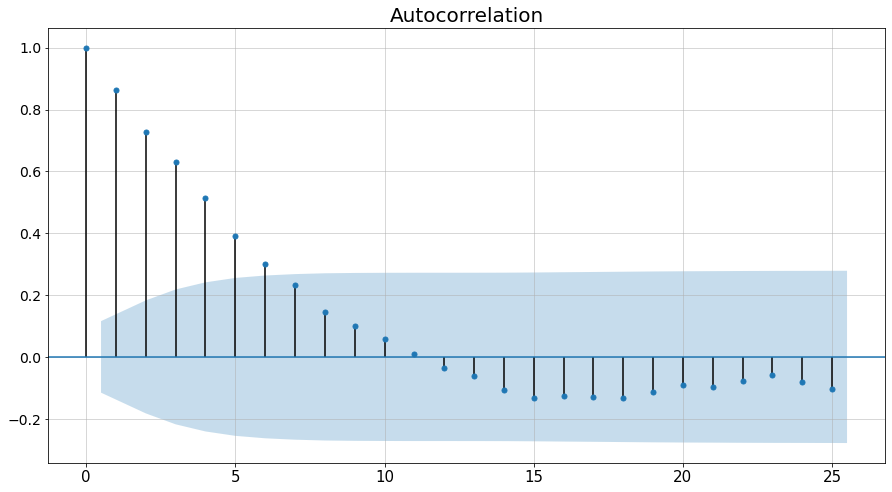

In [25]:
plot_acf(series_remains);

In [26]:
_kf = acf(series_remains, fft=False)[1]
t = (((_kf**2) * (series.size-2)) / (1-_kf**2))**.5

In [27]:
#Смотрим на зону, в которую попадает это число. (Если меньше примерно 1.5, то положительная автокорреляция)
durbin_watson(series_remains)

0.26451300201768707

# Проверка остатков после (trend + Arima) 

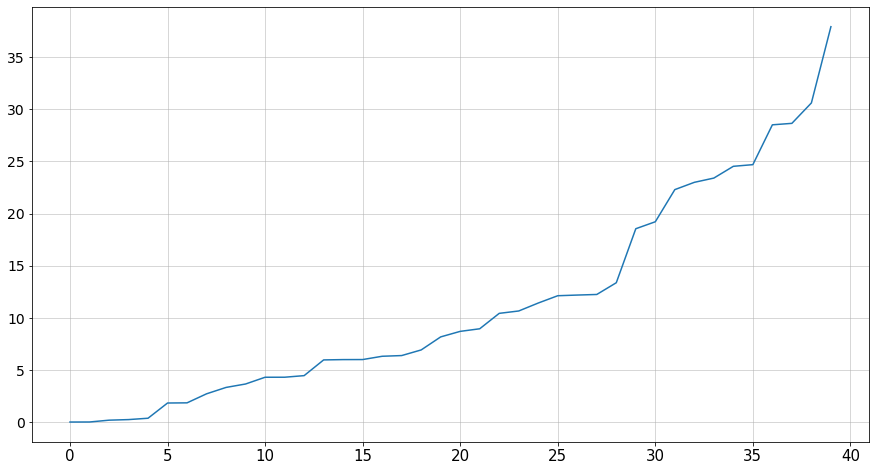

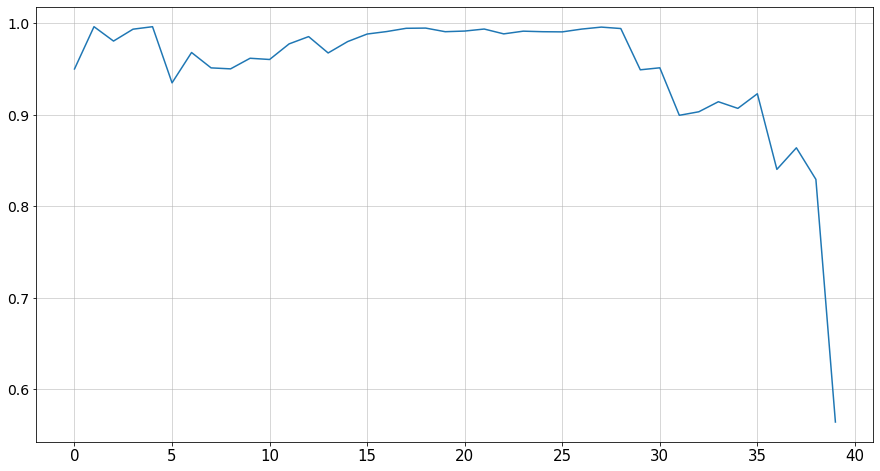

In [28]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [29]:
acorr_ljungbox(arima_by_series_remains.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.003935,0.949980
2,0.007681,0.996167
3,0.181876,0.980461
4,0.238295,0.993441
5,0.368410,0.996155
6,1.828023,0.934816
7,1.844023,0.967967
8,2.710813,0.951175
9,3.323067,0.950099
10,3.652090,0.961680


### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом (поскольку все p-value до 40 лага >0.05)

### Прогноз

In [30]:
_ = []
for i in range(1, 300):
    _.append(5.06432082e+02 + 4.68925631e+01*i - 5.84355075e-01*(i**2) + 2.49624085e-03*(i**3) -3.45926525e-06*(i**4))

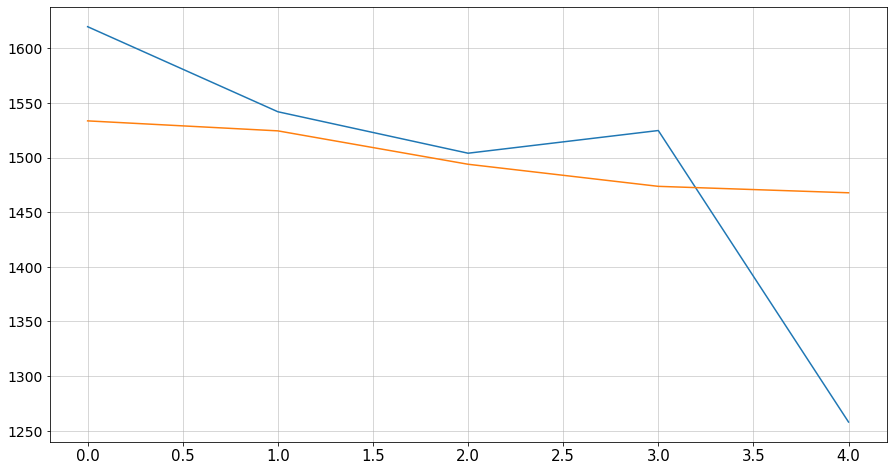

In [31]:
plt.plot(series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy())
plt.plot((arima_by_series_remains.predict('2020', '2020-03') + _[287:292]).to_numpy());

In [32]:
r2_score(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].to_numpy(),
    (arima_by_series_remains.predict('2020', '2020-03') + _[287:292])
)

0.2716538687604373

## ARIMAX с факторами из регрессионного анализа

In [33]:
factors_dir = os.path.join('data', 'factors')

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', ['Date'])
    kwargs.setdefault('index_col', 'Date')
    res = pd.read_csv(*args, **kwargs)
    if res.size < 50:
        res = res.resample('1y').last()
    elif res.size < 600:
        res = res.resample('1m').last()
    else:
        res = res.append(res.resample('1m').last())
    return res


# Создание series'ов и dataframe'ов
factors_csv = os.listdir(factors_dir)
for csv_file in factors_csv:
    if csv_file.startswith('.') or not csv_file.endswith('.csv'):
        continue
    var_name = os.path.splitext(csv_file)[0].lower()
    df_name = f'{var_name}_df'
    series_name = f'{var_name}_series'
    globals()[df_name] = read_csv(os.path.join(factors_dir, csv_file))
    globals()[series_name] = globals()[df_name].Close.resample('1d').last().dropna()
    
all_df = pd.DataFrame({
    # Индекс РТС
    'RTSI': rtsi_series,
    # Индекс S&P 500
    'SP500': sp500_series,
    # FTSE - Англия
    'FTSE': ftse_series,
    # DAX - Германия
    'DAX': dax_series,
    # SSE - Китай
    'SSE': sse_series,
    # Нефть Brent
    'Brent': brent_series,
    # USD/RUB
    'USD': usd_series,
    # Темпы роста ВВП РФ
    # 'GDP': gdp_series,
    # Золото
    'Gold': gold_series,
    # Уровень безработицы в РФ
    'Unemployment': unemployment_series,
    # Индекс потребительских цен
    # 'CPI': cpi_series,
    # Индекс потребительских цен погодично
    # 'CPI_year': cpi_year_series,
    # Индекс потребительских цен относительно 2000 года
    # 'CPI2000': cpi2000_series,
    # Индекс потребительских цен относительно 1996 года
    # 'CPI1996': cpi1996_series,
    # Ставки по межбанковским кредитам
    'InterbankRate': interbank_rate_series,
    # Доходность 6 месячных облигаций США
    'USA6mBond': usa_6m_bond_series,
    # Инвестиции в основной капитал
    # 'capital_investment': capital_investment_series,
    # Внешняя торговля РФ
    'international_trade': international_trade_series,
    # Индекс производительности труда
    'labor_performance': labor_performance_series,
    # Индекс промышленного производства
    'industrial_production': industrial_production_series,
    # Ключевая ставка
    'key_rate': key_rate_series,
    # Остатки на корреспондентских счетах
    # 'correspondent_accounts': correspondent_accounts_series,
    # Остатки на корреспондентских счетах (средние скорректированные)
    'correspondent_accounts_mean_scorr': correspondent_accounts_mean_scorr_series,
    # Номинальная зарплата
    # 'nominal_salary': nominal_salary_series,
    # Скорректированная номинальная зарплата
    'nominal_salary_scorr': nominal_salary_scorr_series,
    # ВВП РФ в абсолютном значении
    # 'abs_gdp': abs_gdp_series,
    # Скорректированный ВВП РФ в абсолютном значении
    'abs_gdp_scorr': abs_gdp_scorr_series,
    # Скорректированные инвестиции в основной капитал
    'capital_investment_scorr': capital_investment_series
})

In [34]:
test_df2 = all_df['2009':'2019'].resample('14d').last().copy()
arimax = sm.tsa.statespace.SARIMAX(
    test_df2['RTSI'], order=(1,1,1), seasonal_order=(0,0,0,0), exog=test_df2[['Brent', 'SP500']]
).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   RTSI   No. Observations:                  287
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1551.090
Date:                Tue, 14 Apr 2020   AIC                           3112.180
Time:                        22:32:38   BIC                           3130.460
Sample:                    01-01-2009   HQIC                          3119.507
                         - 12-19-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Brent          7.2067      0.765      9.426      0.000       5.708       8.705
SP500          0.5437      0.064      8.441      0.000       0.417       0.670
ar.L1         -0.8190      0.210     -3.893      0.000      -1.231      -0.407
ma.L1          0.7593      0.239      3.181      0.001       0.291       1.227
sigma2      3009.3227    204.355     14.726      0.000    2608.794    3409.851
===================================================================================
Ljung-Box (Q):                       66.49   Jarque-Bera (JB):                52.20
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

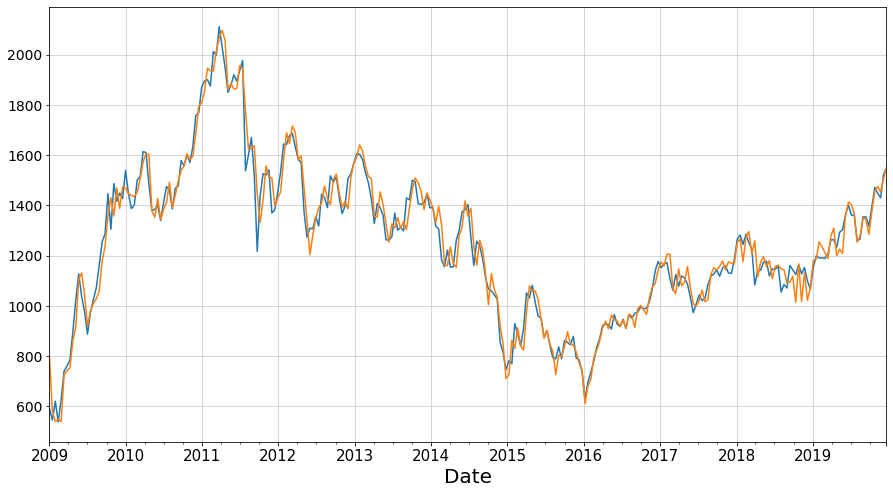

In [35]:
test_df2.RTSI.plot()
arimax.fittedvalues.plot();

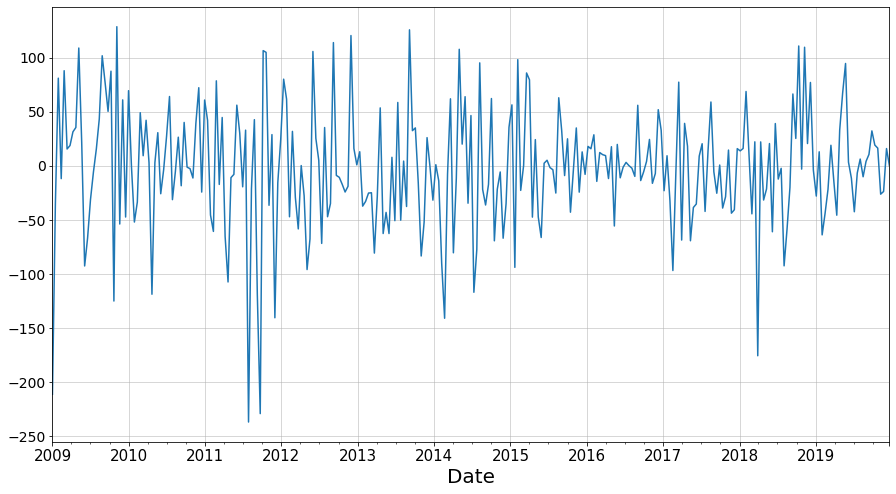

In [36]:
arimax.resid.plot()

### Прогноз

In [37]:
arimax_predict = arimax.predict(
    '2020-01-01', '2020-02-15',
    exog=all_df[['Brent', 'SP500']]['2020':].resample('14d').last()[:5]
)
r2_score(
    rtsi_series['2020':].resample('14d').last()[:5], arimax_predict
)

0.8740806187198035

# ARIMA на исходные данные 

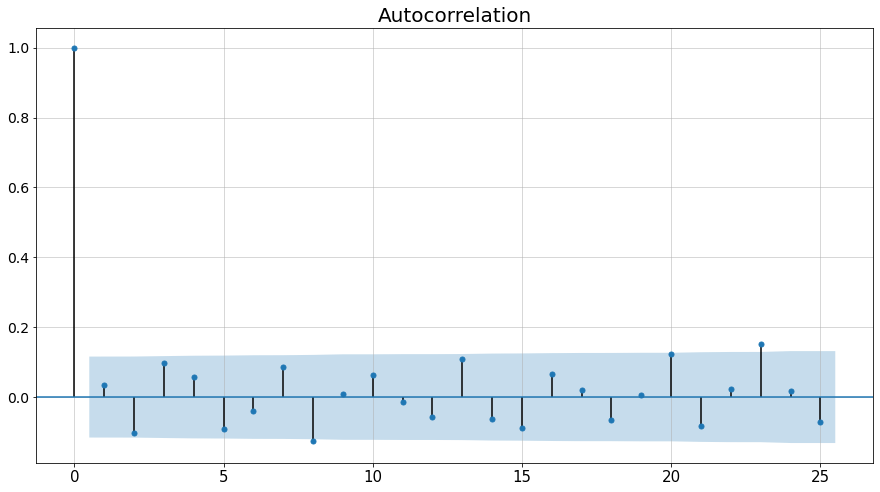

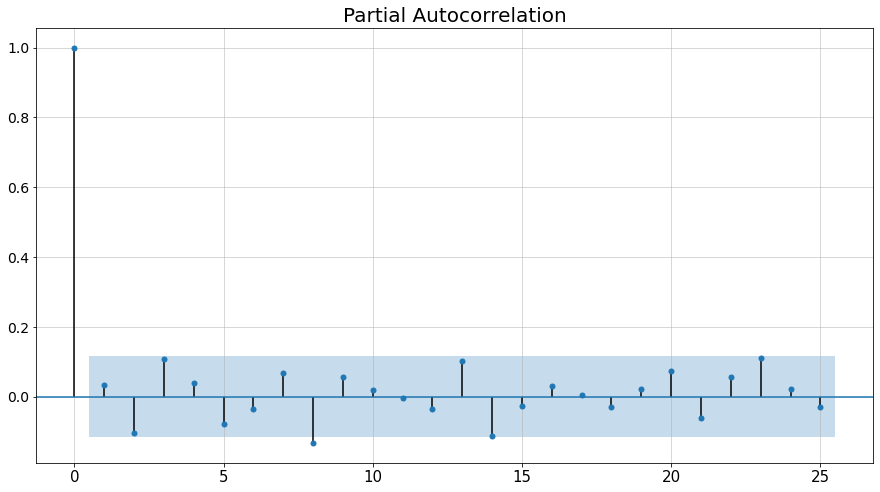

In [38]:
plot_acf(np.diff(series))
plot_pacf(np.diff(series));

In [39]:
arima_by_series = ARIMA(series, order=(3, 1, 3)).fit()

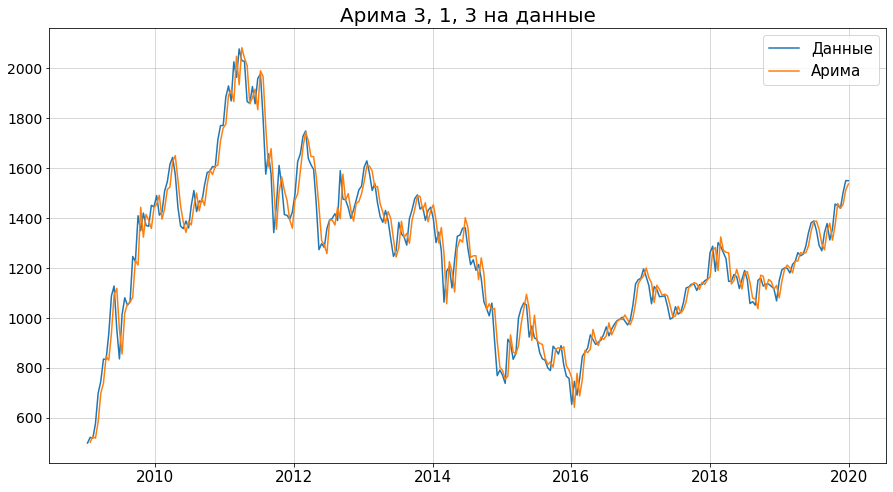

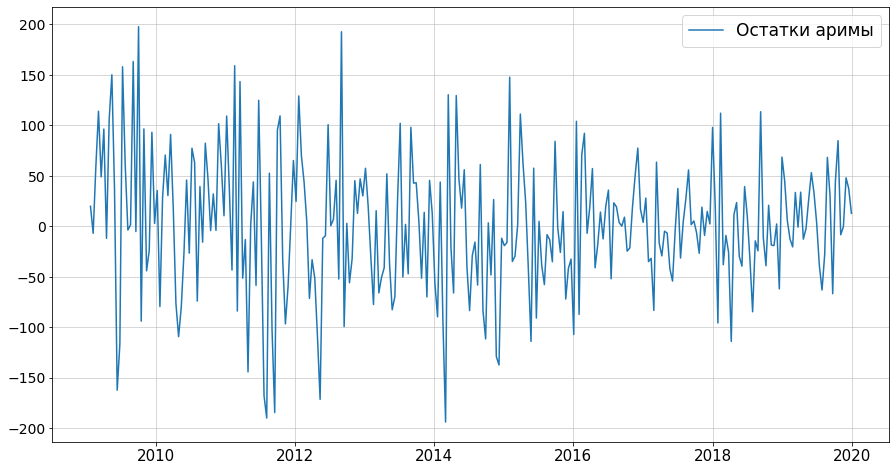

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  286
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1608.834
Method:                       css-mle   S.D. of innovations             66.957
Date:                Tue, 14 Apr 2020   AIC                           3233.667
Time:                        22:32:42   BIC                           3262.915
Sample:                    01-25-2009   HQIC                          3245.391
                         - 12-29-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.9196      2.906      1.005      0.315      -2.776       8.615
ar.L1.D.Close     0.2751      0.049      5.567      0.000       0.178       0.372
ar.L2.D.Close    -0.2340      0.041     -5.744      0.000      -0.314      -0.154
ar.L3.D.Close     0.9383      0.037     25.038      0.000       0.865       1.012
ma.L1.D.Close    -0.2345      0.062     -3.763      0.000      -0.357      -0.112
ma.L2.D.Close     0.1374      0.046      3.001      0.003       0.048       0.227
ma.L3.D.Close    -0.9028      0.062    -14.543      0.000      -1.025      -0.781
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0078           -0.0000j            1.0078           -0.0000
AR.2           -0.3792           -0.9559j            1.0284           -0.3101
AR.3           -0.3792           +0.9559j            1.0284            0.3101
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.4239           -0.9633j            1.0524           -0.3160
MA.3           -0.4239           +0.9633j            1.0524            0.3160
-----------------------------------------------------------------------------
"""

In [40]:
plt.plot(series, label='Данные')
plt.plot(series - arima_by_series.resid, label='Арима')
plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(arima_by_series.resid, label='Остатки аримы')
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

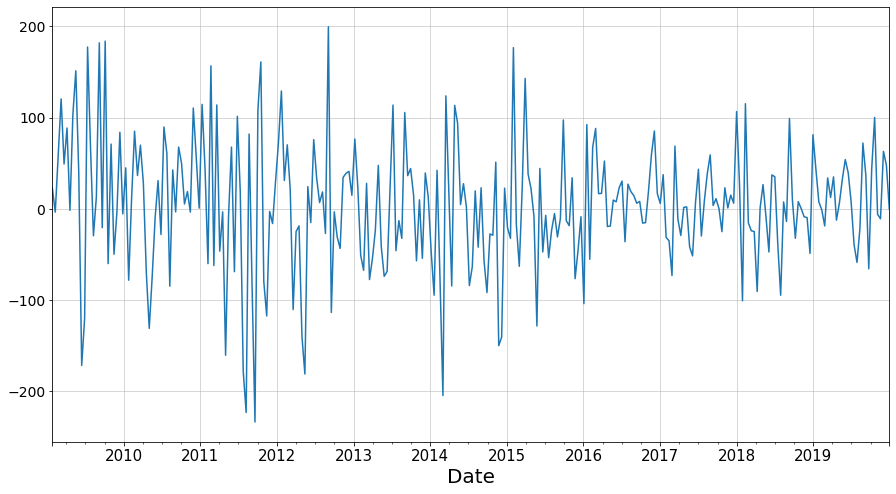

In [41]:
(arima_by_series.fittedvalues + arima_by_series.resid).plot();

### Проверим остатки от этой ARIMA на белый шум

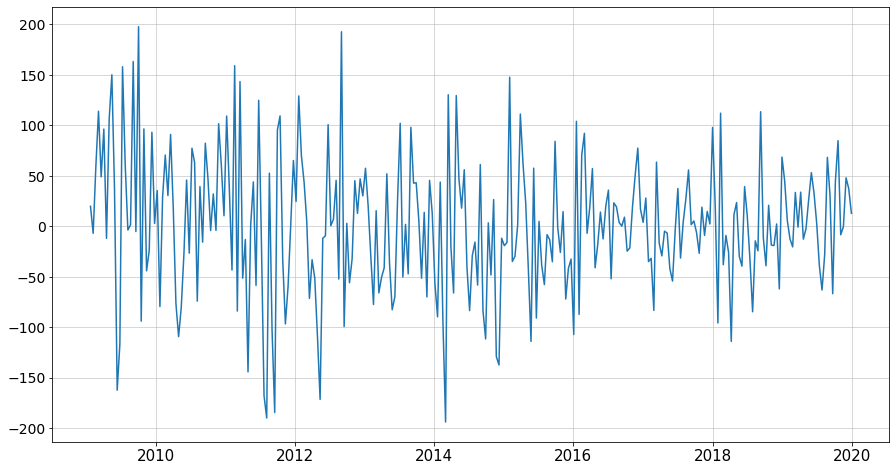

In [42]:
plt.plot(arima_by_series.resid, label='Остатки аримы');

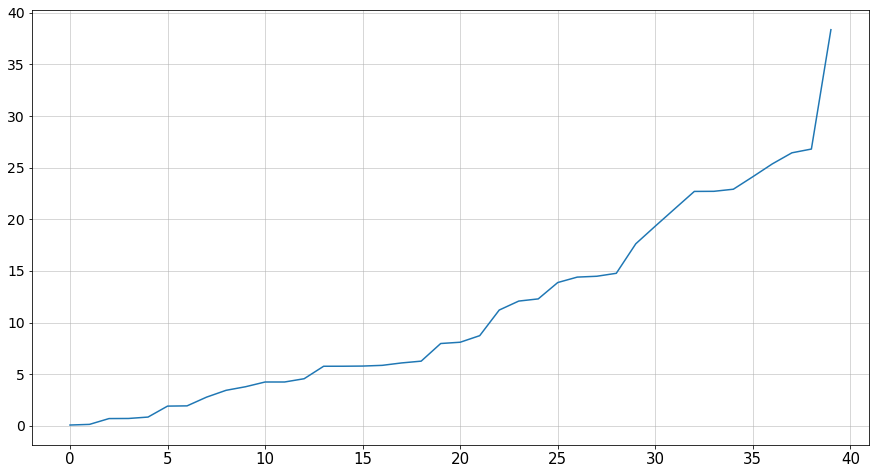

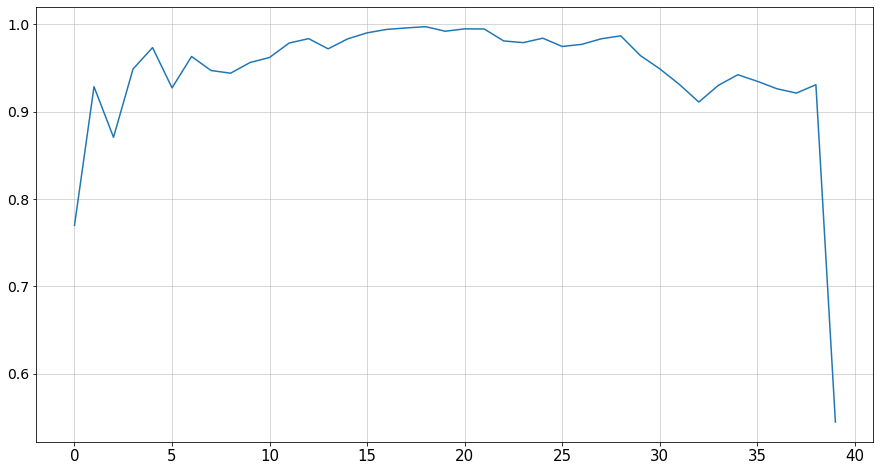

In [43]:
q_test = acf(arima_by_series.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

In [44]:
acorr_ljungbox(arima_by_series.resid, return_df=True)
# H0 - данные являются "белым шумом"
# Также можно сверить Q статистику с таблицей распределения ХИ-КВАДРАТ

,lb_stat,lb_pvalue
1,0.085701,0.769715
2,0.148442,0.928466
3,0.711195,0.870568
4,0.721038,0.948709
5,0.856510,0.973290
6,1.917207,0.927153
7,1.940693,0.963050
8,2.786535,0.947031
9,3.446305,0.943950
10,3.793441,0.956184


### Прогноз

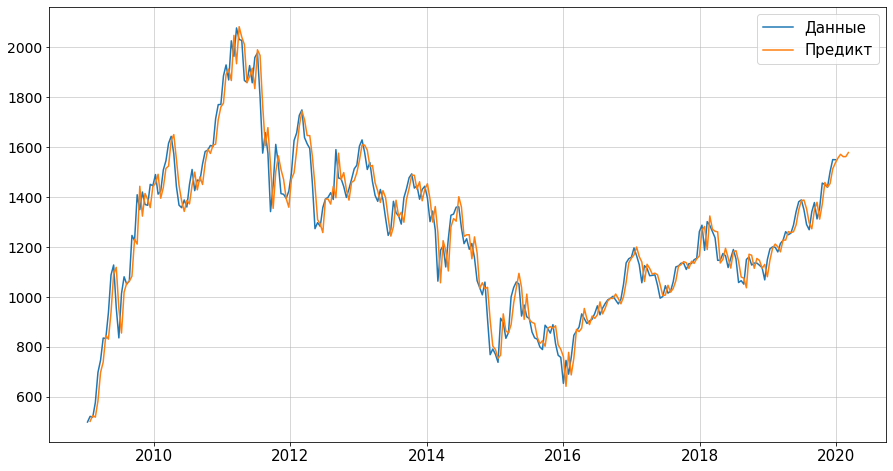

In [45]:
start = series[-1]
predicted = arima_by_series.predict('2020', '2020-03')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

In [46]:
series2020 = df['2020':].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020['2020':]

In [47]:
predicted.values

array([1555.46561792, 1570.50985495, 1561.14765737, 1561.25377055,
       1577.64928414])

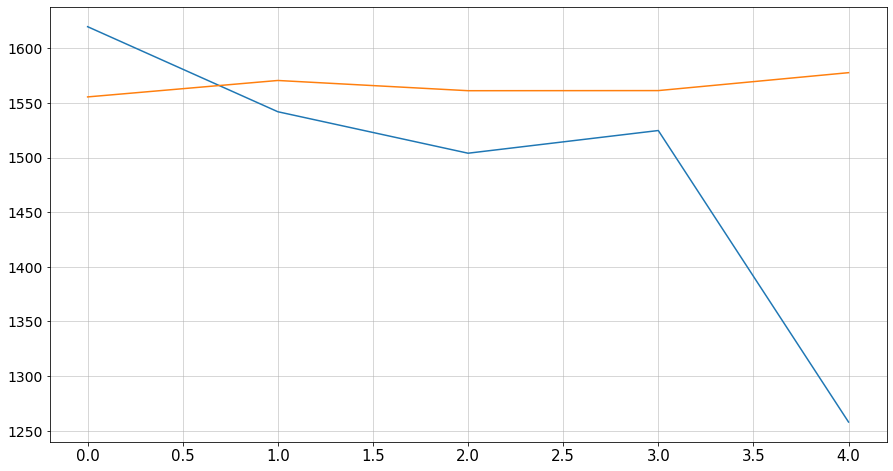

In [48]:
plt.plot(
    series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])].values)
plt.plot(
    predicted.values
);

In [49]:
ser1 = series2020[series2020.index.isin(['2020-01-13', '2020-01-27', '2020-02-10', '2020-02-21', '2020-03-06'])]
ser2 = pd.Series(data=predicted.values, index=ser1.index)
r2_score(ser1.to_numpy(), ser2.to_numpy())

-0.49477647730554164

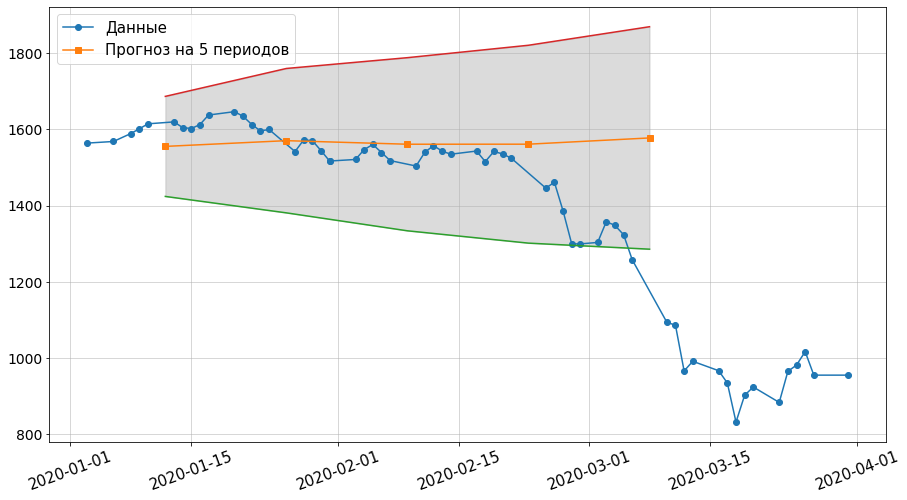

In [50]:
plt.plot(series2020, label='Данные', marker='o')
plt.plot(predicted, label='Прогноз на 5 периодов', marker='s')
plt.plot(pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.plot(pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index))
plt.fill_between(
    predicted.index, 
    pd.Series(map(lambda x: x[0], arima_by_series.forecast(5)[2]), index=predicted.index),
    pd.Series(map(lambda x: x[1], arima_by_series.forecast(5)[2]), index=predicted.index),
    color=((.3, .3, .3, .2), )
)
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [51]:
# Оптимальный '2011-10-31' / '2016-03-31'
#chow_test_result, split_point1, partial_series = \
#     Model(series['2011-06': ] ).cut_by_chow_test(arbitrarily=2, with_result=True)
#draw(partial_series)

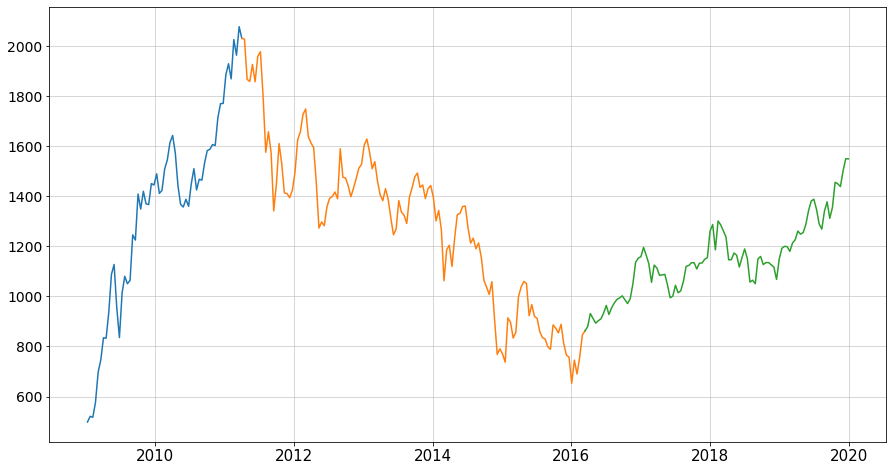

In [52]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)

### 1-ый кусок

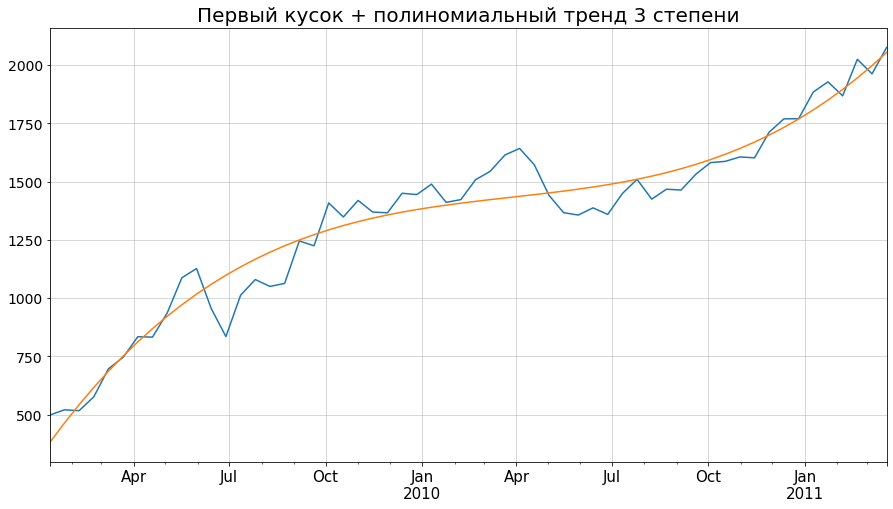

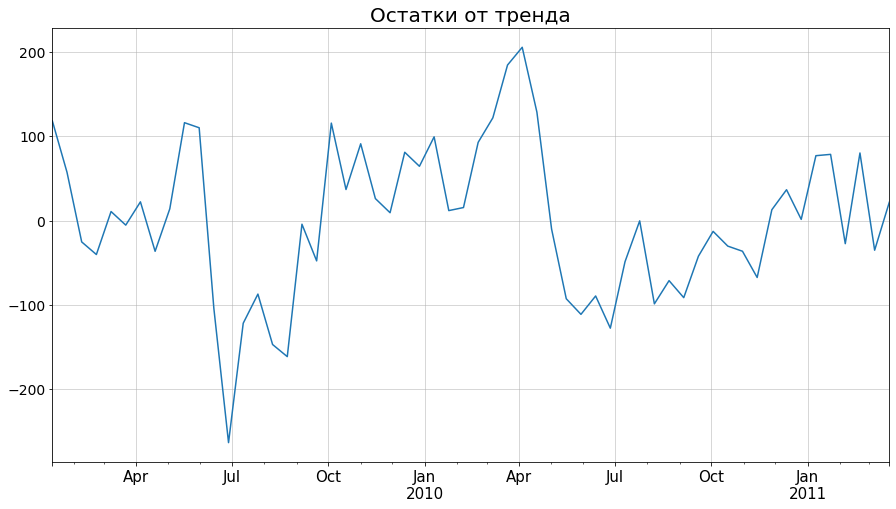

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     314.1
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           3.82e-34
Time:                        22:32:45   Log-Likelihood:                -342.83
No. Observations:                  58   AIC:                             693.7
Df Residuals:                      54   BIC:                             701.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        291.3398     51.926      5.611      0.000     187.234     395.445
x1            91.2751      7.557     12.078      0.000      76.124     106.426
x2            -2.5905      0.296     -8.744      0.000      -3.184      -1.997
x3             0.0266      0.003      8.046      0.000       0.020       0.033
==============================================================================
Omnibus:                        0.804   Durbin-Watson:                   0.715
Prob(Omnibus):                  0.669   Jarque-Bera (JB):                0.357
Skew:                          -0.173   Prob(JB):                        0.837
Kurtosis:                       3.169   Cond. No.                     3.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p1.polynomial_trend(3).fitted_model.summary())

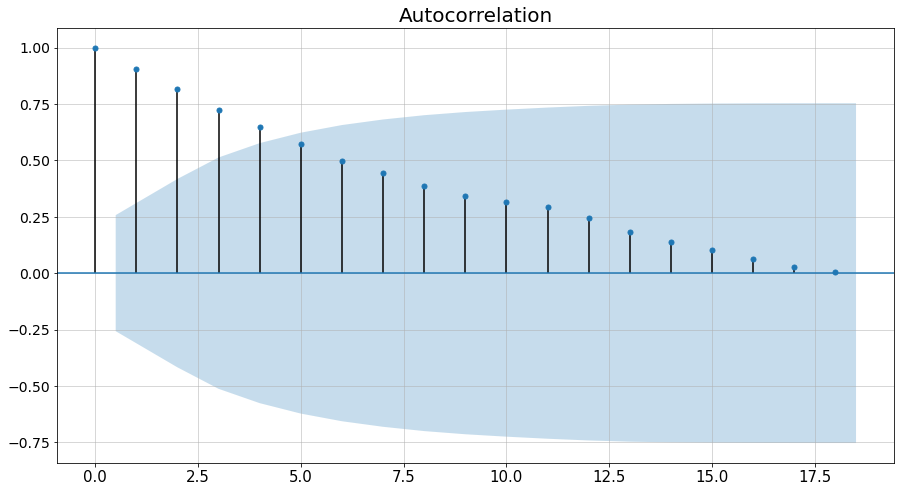

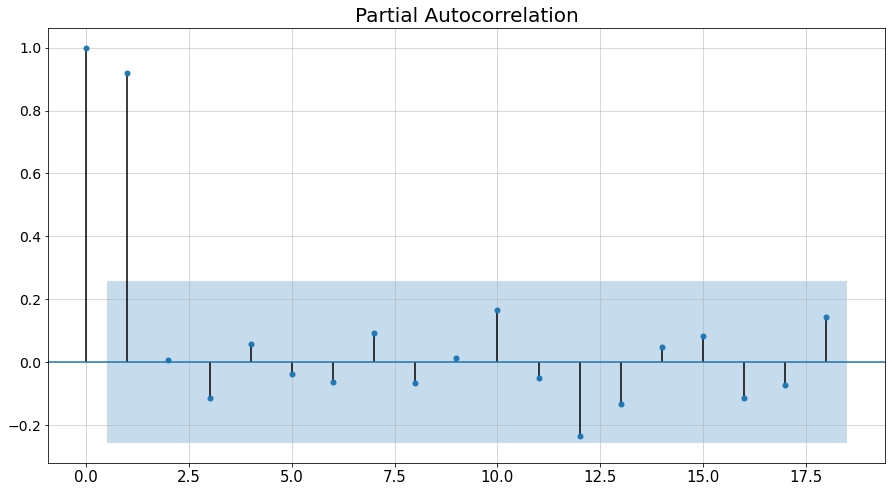

In [54]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

### 2-ой кусок 

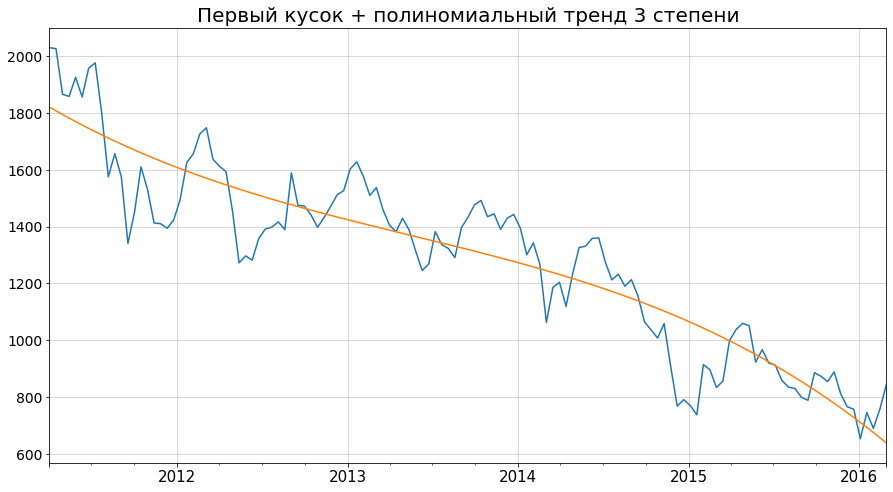

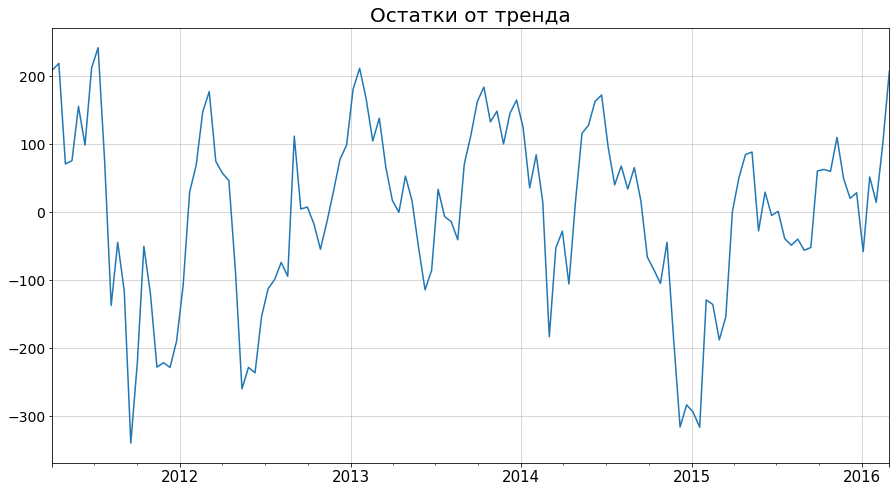

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     219.5
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.25e-49
Time:                        22:32:46   Log-Likelihood:                -810.60
No. Observations:                 129   AIC:                             1629.
Df Residuals:                     125   BIC:                             1641.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1834.4483     47.763     38.407      0.000    1739.919    1928.977
x1           -13.5544      3.170     -4.276      0.000     -19.827      -7.281
x2             0.1411      0.057      2.495      0.014       0.029       0.253
x3            -0.0008      0.000     -2.925      0.004      -0.001      -0.000
==============================================================================
Omnibus:                        6.084   Durbin-Watson:                   0.370
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.278
Skew:                          -0.530   Prob(JB):                       0.0433
Kurtosis:                       2.785   Cond. No.                     3.39e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
partial_series.p2.plot()
partial_series.p2.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p2.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p2.polynomial_trend(3).fitted_model.summary())

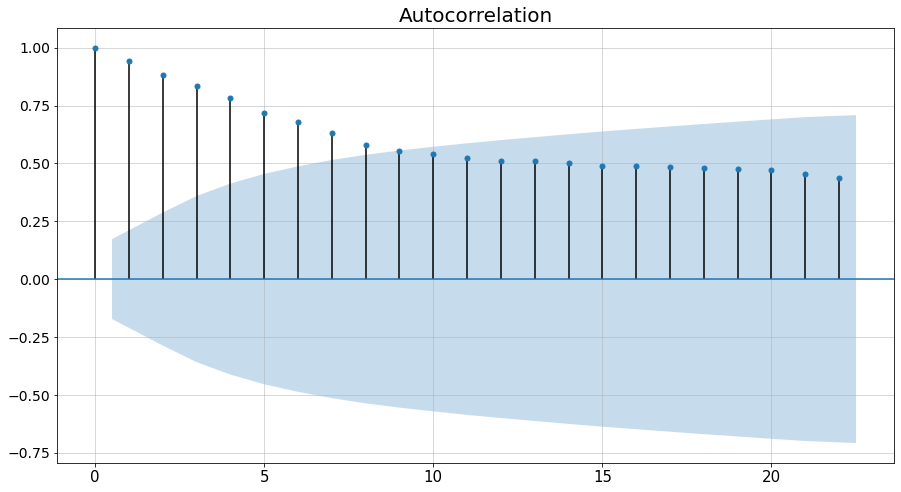

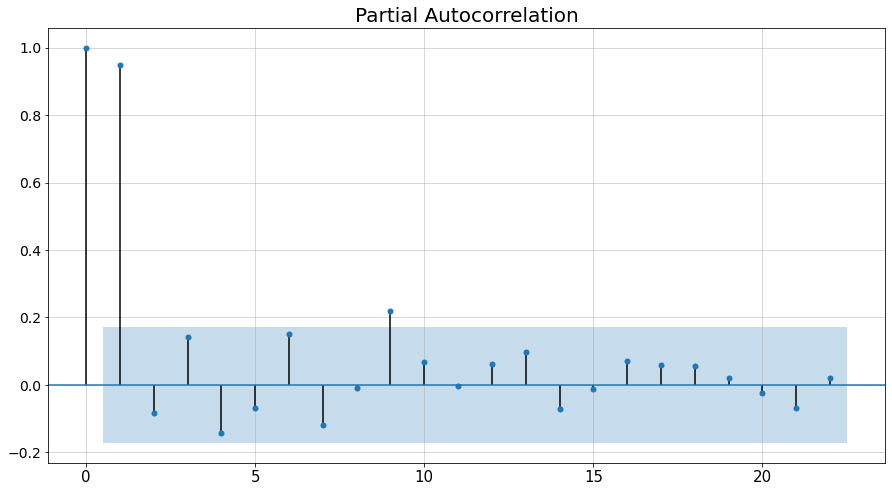

In [56]:
plot_acf(partial_series.p2)
plot_pacf(partial_series.p2);

### 3-ий кусок

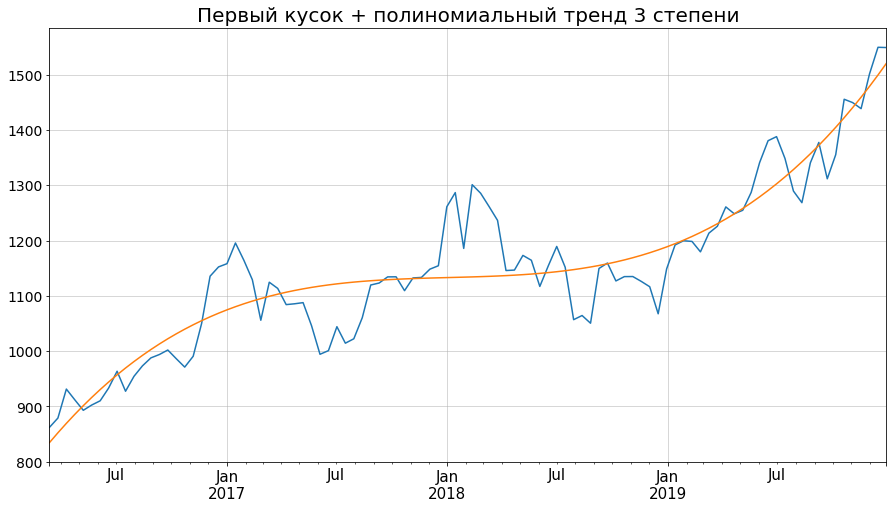

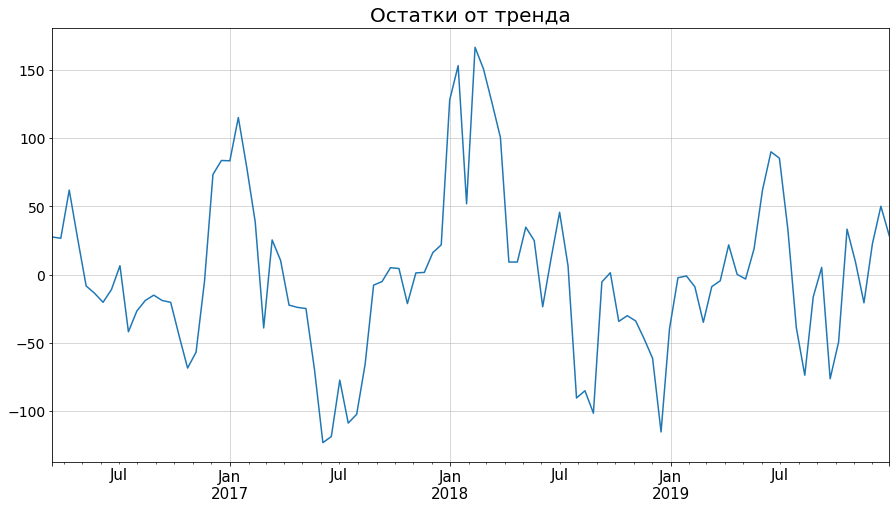

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     172.3
Date:                Tue, 14 Apr 2020   Prob (F-statistic):           1.64e-38
Time:                        22:32:47   Log-Likelihood:                -550.01
No. Observations:                 100   AIC:                             1108.
Df Residuals:                      96   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        816.1133     25.110     32.502      0.000     766.271     865.956
x1            18.9131      2.142      8.828      0.000      14.661      23.166
x2            -0.3837      0.049     -7.805      0.000      -0.481      -0.286
x3             0.0026      0.000      8.280      0.000       0.002       0.003
==============================================================================
Omnibus:                        5.162   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                4.494
Skew:                           0.458   Prob(JB):                        0.106
Kurtosis:                       3.491   Cond. No.                     1.60e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
partial_series.p3.plot()
partial_series.p3.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p3.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()
display(partial_series.p3.polynomial_trend(3).fitted_model.summary())

### Выведем склеенный тренд и применим на все остатки ARIMA

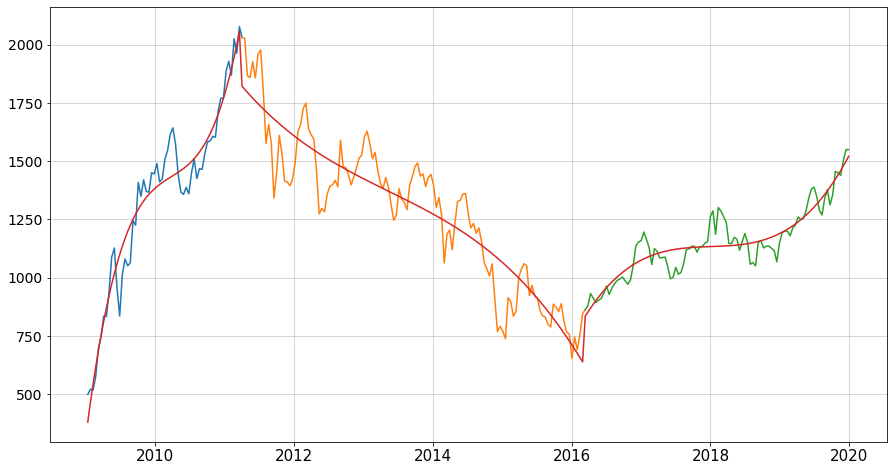

In [58]:
draw(partial_series);
partial_series_trend = (
    partial_series.p1.polynomial_trend(3)
    .append(partial_series.p2.polynomial_trend(3))
    .append(partial_series.p3.polynomial_trend(3))
)
partial_series_trend_remains = (series - partial_series_trend)
draw(partial_series_trend);

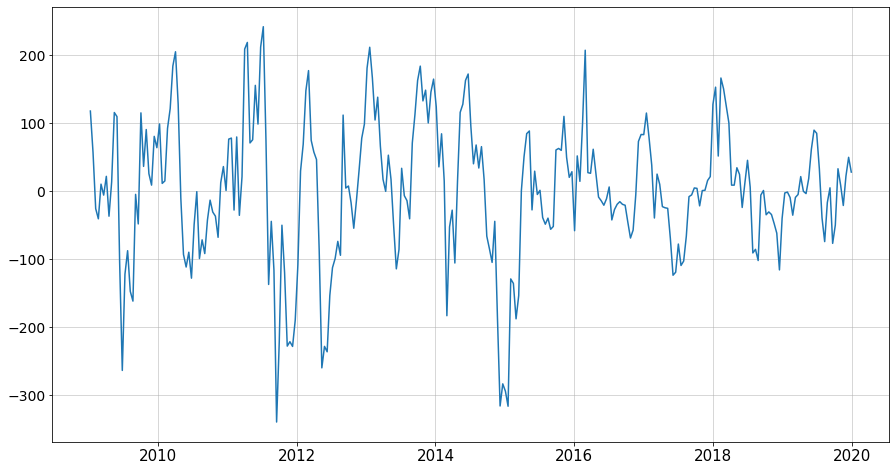

In [59]:
draw(partial_series_trend_remains);

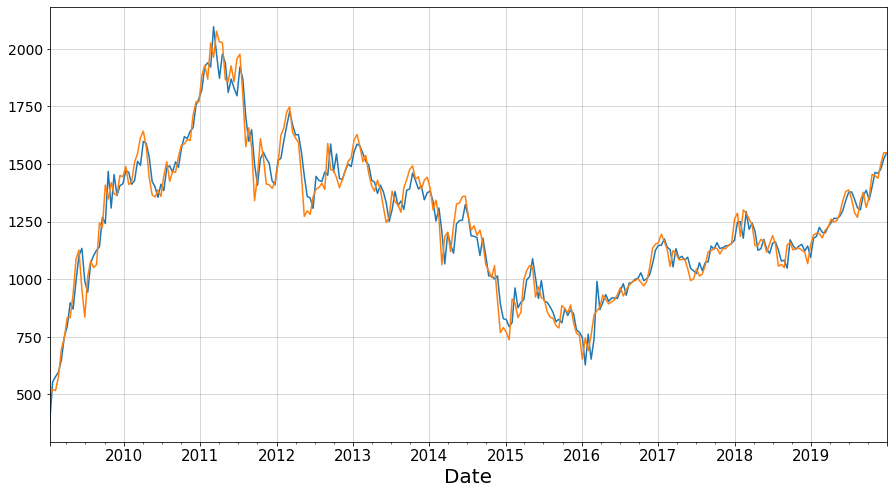

In [102]:
arima_by_partial_series_trend_remains = ARIMA(partial_series_trend_remains, order=(5, 0, 4)).fit()
(partial_series_trend + arima_by_partial_series_trend_remains.fittedvalues).plot()
series.plot();

### Прогноз

In [94]:
params = partial_series.p3.polynomial_trend(3).fitted_model.params
params

const    816.113301
x1        18.913095
x2        -0.383668
x3         0.002650
dtype: float64

In [106]:
__ = []
for i in range(106):
    __.append(params.const + params.x1*i + params.x2 * i**2 + params.x3*i**3)

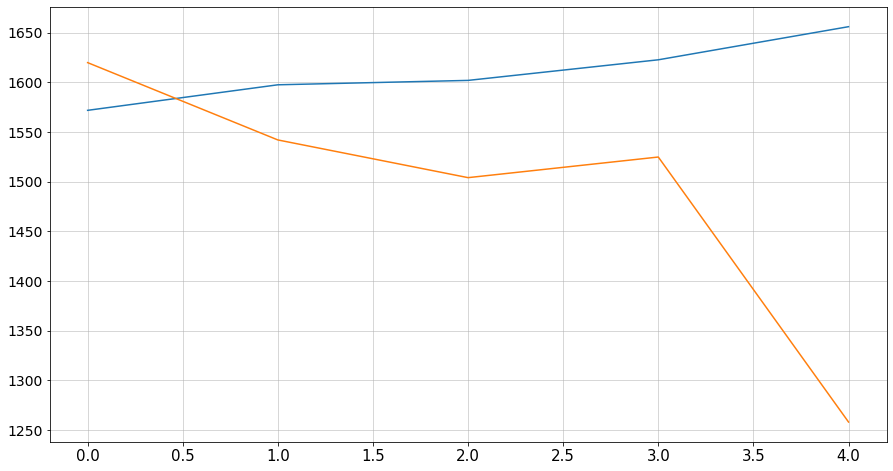

In [112]:
plt.plot((arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]).to_numpy())
plt.plot(ser1.to_numpy())

In [114]:
r2_score(
    (arima_by_partial_series_trend_remains.predict('2020', '2020-03') + __[-5:]),
    ser1
)

-45.22473700447689

# Holt-Winters

In [61]:
holt_winters = ExponentialSmoothing(series, seasonal_periods=9, trend='add', seasonal='mul', damped=True).fit()
holt_winters.summary()

Dep. Variable:,endog,No. Observations:,287
Model:,ExponentialSmoothing,SSE,1326297.649
Optimized:,True,AIC,2449.826
Trend:,Additive,BIC,2501.059
Seasonal:,Multiplicative,AICC,2451.841
Seasonal Periods:,9,Date:,"Tue, 14 Apr 2020"
Box-Cox:,False,Time:,22:32:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_slope,0.0549084,beta,True


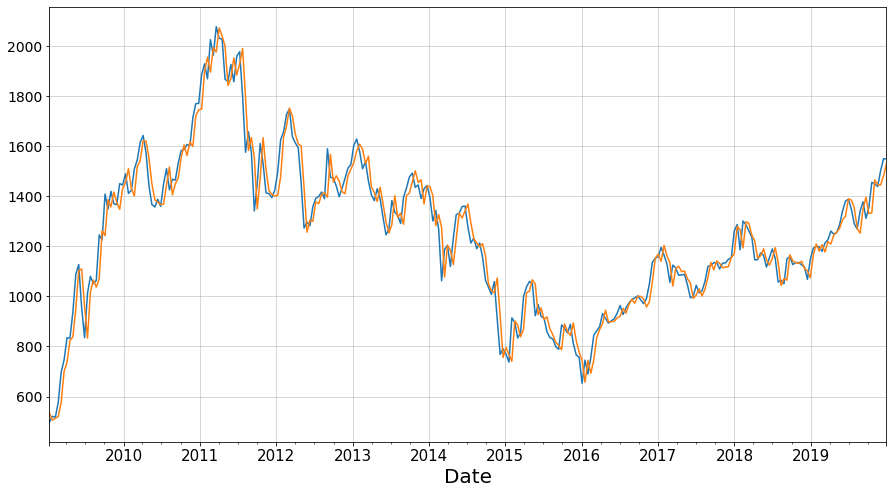

In [62]:
series.plot()
holt_winters.fittedvalues.plot();

In [63]:
Model(series).aic(holt_winters.fittedvalues, 5)

8.473262885487772

In [64]:
holt_winters.forecast(4)

2020-01-12    1558.486473
2020-01-26    1579.758696
2020-02-09    1602.508695
2020-02-23    1577.477932
Freq: 14D, dtype: float64

### Оценивание точности

In [65]:
def mape(other1, other):
    """ Критерий MAPE """
    return np.mean(np.abs((other1 - other) / other1)) * 100

def mae(other1, other):
    """ Критерий MAE """
    return np.mean(np.abs(other1 - other))

##### ARIMAX (тренд + ARIMA на остатки)

In [66]:
print(mape(series, series_trend + arima_by_series_remains.fittedvalues))
print(mae(series, series_trend + arima_by_series_remains.fittedvalues))
r2_score(series, series_trend + arima_by_series_remains.fittedvalues)

4.036500576064836
48.36348884959209


0.9567316791871657

##### ARIMA на исходные данные

In [67]:
print(mape(series, series - arima_by_series.resid))
print(mae(series, series - arima_by_series.resid))
r2_score(series.iloc[1:], (series - arima_by_series.resid).iloc[1:])

4.259970545298598
51.25130988968329


0.9494755153184185

##### ARIMAX с CHOW TEST

In [68]:
print(mape(series, (partial_series_trend + _.fittedvalues)))
print(mae(series, (partial_series_trend + _.fittedvalues)))
r2_score(series, (partial_series_trend + _.fittedvalues))

3.983088444004671
46.95951079637826


0.959606466166461

##### ARIMAX с факторами из регрессионого анализа

In [69]:
print(mape(test_df2.RTSI, arimax.fittedvalues))
print(mae(test_df2.RTSI, arimax.fittedvalues))
r2_score(test_df2.RTSI, arimax.fittedvalues)

3.48661312176252
41.37996230595056


0.9647403064838198

##### Holt-Winters

In [70]:
print(mape(series, holt_winters.fittedvalues))
print(mae(series, holt_winters.fittedvalues))
r2_score(series, holt_winters.fittedvalues)

4.222533536036898
50.824913818545994


0.9491831166421945

# ARX-GARCH модель

In [71]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), test_df2['Brent'].resample('14d').last().to_numpy()[:, np.newaxis], lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    AR-X - Constant Variance Model Results                    
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Mean Model:                      AR-X   Adj. R-squared:                  0.947
Vol Model:          Constant Variance   Log-Likelihood:               -1614.39
Distribution:                  Normal   AIC:                           3236.77
Method:            Maximum Likelihood   BIC:                           3251.40
                                        No. Observations:                  286
Date:                Tue, Apr 14 2020   Df Residuals:                      282
Time:                        22:32:53   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         47.9475     18.914      2.535  1.125e-02 [ 10.876, 85.019]
y[1]           0.9723  2.408e-02     40.373      0.000 [  0.925,  1.020]
x0            -0.1228      0.264     -0.465      0.642 [ -0.640,  0.394]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      4682.2941    469.182      9.980  1.870e-23 [3.763e+03,5.602e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1596.6242497727262
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1596.5858196115473
Iteration:      3,   Func. Count:     32,   Neg. LLF: 1596.5843498430395
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1596.5752473968687
Iteration:      5,   Func. Count:     51,   Neg. LLF: 1596.5715441546054
Iteration:      6,   Func. Count:     60,   Neg. LLF: 1596.5567493890626
Iteration:      7,   Func. Count:     68,   Neg. LLF: 1596.55341554182
Iteration:      8,   Func. Count:     76,   Neg. LLF: 1596.5510655434066
Iteration:      9,   Func. Count:     84,   Neg. LLF: 1596.5366480444018
Iteration:     10,   Func. Count:     92,   Neg. LLF: 1596.4692771399812
Iteration:     11,   Func. Count:    100,   Neg. LLF: 1596.3295435499926
Iteration:     12,   Func. Count:    108,   Neg. LLF: 1596.3277082554173
Iteration:     13,   Func. Count:    116,   Neg. LLF: 1596.3275857832214
Iteration:     14,   Func. Count:    124,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Mean Model:                      AR-X   Adj. R-squared:                  0.947
Vol Model:                      GARCH   Log-Likelihood:               -1596.32
Distribution:                  Normal   AIC:                           3204.64
Method:            Maximum Likelihood   BIC:                           3226.58
                                        No. Observations:                  286
Date:                Tue, Apr 14 2020   Df Residuals:                      280
Time:                        22:32:53   Df Model:                            6
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         36.2749     18.517      1.959  5.011e-02 [-1.755e-02, 72.567]
y[1]           0.9808  2.568e-02     38.198      0.000    [  0.931,  1.031]
x0            -0.1211      0.267     -0.454      0.650    [ -0.644,  0.402]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        102.6534    105.186      0.976      0.329 [-1.035e+02,3.088e+02]
alpha[1]       0.0979  6.498e-02      1.507      0.132   [-2.942e-02,  0.225]
beta[1]        0.8790  7.507e-02     11.710  1.139e-31      [  0.732,  1.026]
=============================================================================

Covariance estimator: robust
"""

In [72]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('14d').last()

ar_by_week_series = ARX(week_series.to_numpy(), lags=1)
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Mean Model:                        AR   Adj. R-squared:                  0.947
Vol Model:          Constant Variance   Log-Likelihood:               -1614.50
Distribution:                  Normal   AIC:                           3235.00
Method:            Maximum Likelihood   BIC:                           3245.97
                                        No. Observations:                  286
Date:                Tue, Apr 14 2020   Df Residuals:                      283
Time:                        22:32:53   Df Model:                            3
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         48.2375     18.788      2.567  1.024e-02 [ 11.414, 85.061]
y[1]           0.9644  1.537e-02     62.763      0.000 [  0.934,  0.994]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      4686.0489    469.840      9.974  1.987e-23 [3.765e+03,5.607e+03]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1596.6633890591002
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1596.6509132029216
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1596.6508660384957
Iteration:      4,   Func. Count:     39,   Neg. LLF: 1596.6445576374867
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1596.6425271765386
Iteration:      6,   Func. Count:     53,   Neg. LLF: 1596.6392623199736
Iteration:      7,   Func. Count:     60,   Neg. LLF: 1596.6263564718595
Iteration:      8,   Func. Count:     67,   Neg. LLF: 1596.601546485755
Iteration:      9,   Func. Count:     74,   Neg. LLF: 1596.55268770175
Iteration:     10,   Func. Count:     81,   Neg. LLF: 1596.4980426126099
Iteration:     11,   Func. Count:     88,   Neg. LLF: 1596.4676235817008
Iteration:     12,   Func. Count:     95,   Neg. LLF: 1596.4620052819978
Iteration:     13,   Func. Count:    102,   Neg. LLF: 1596.4616766108893
Iteration:     14,   Func. Count:    109,   Neg. LLF: 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Mean Model:                        AR   Adj. R-squared:                  0.947
Vol Model:                      GARCH   Log-Likelihood:               -1596.45
Distribution:                  Normal   AIC:                           3202.90
Method:            Maximum Likelihood   BIC:                           3221.18
                                        No. Observations:                  286
Date:                Tue, Apr 14 2020   Df Residuals:                      281
Time:                        22:32:53   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const         37.9550     17.553      2.162  3.059e-02 [  3.552, 72.358]
y[1]           0.9723  1.534e-02     63.397      0.000 [  0.942,  1.002]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega        107.1731    105.112      1.020      0.308  [-98.843,3.132e+02]
alpha[1]       0.1012  6.537e-02      1.548      0.122 [-2.695e-02,  0.229]
beta[1]        0.8753  7.436e-02     11.770  5.589e-32    [  0.730,  1.021]
===========================================================================

Covariance estimator: robust
"""

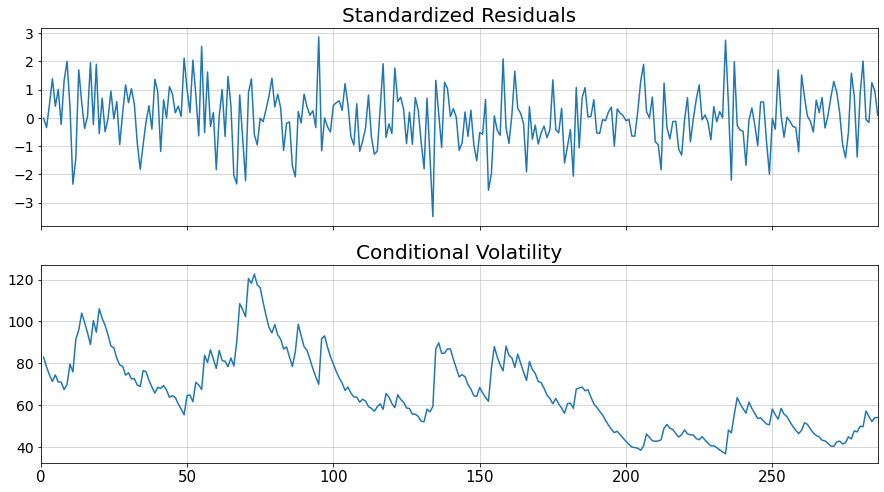

In [73]:
argarch_by_week_series_fitted.plot();

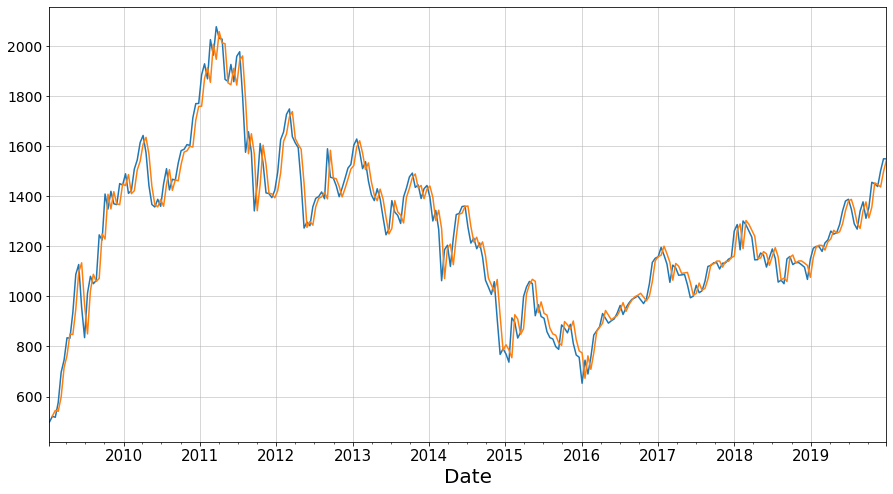

In [74]:
week_series.plot()
(week_series - argarch_by_week_series_fitted.resid).plot();

In [75]:
print(mape(week_series, (week_series - argarch_by_week_series_fitted.resid)))
mae(week_series, (week_series - argarch_by_week_series_fitted.resid))

4.240031266382601


51.19942875407662

In [76]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

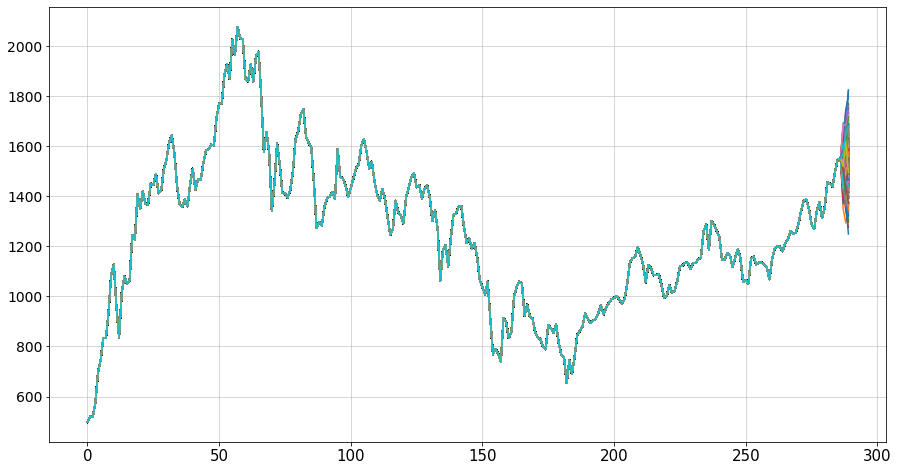

In [77]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:],
        np.append(week_series.to_list(), _)[:]
    )
    _.clear()

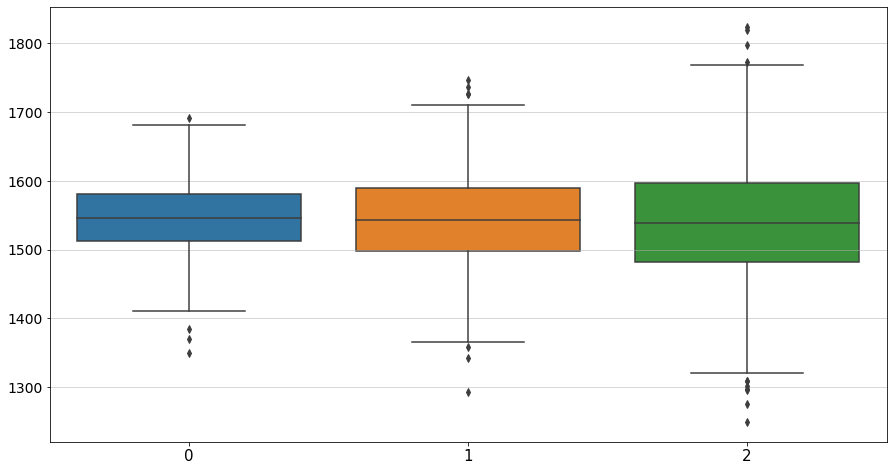

In [78]:
sns.boxplot(data=q[-1]);

# VAR модель

[-2.61042798 -1.72040624]


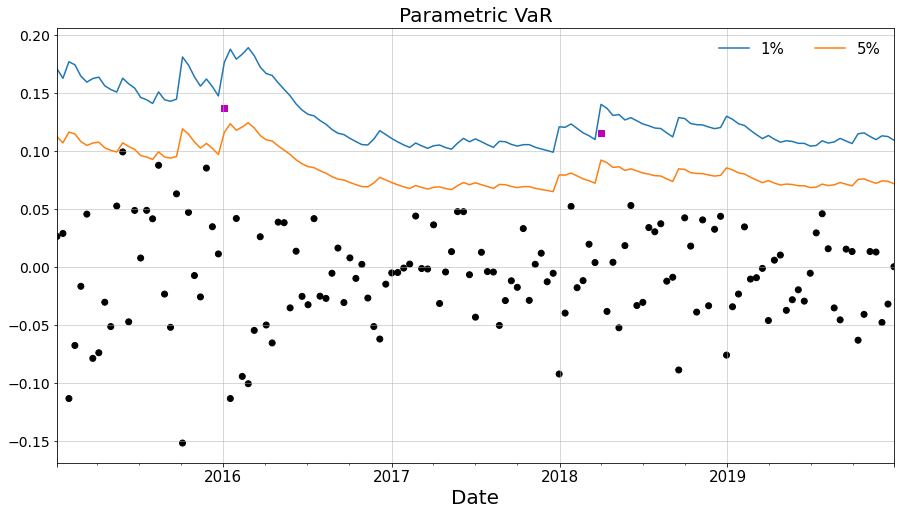

In [79]:
# week_series_changed = arch.data.sp500.load()['Adj Close'].pct_change().dropna() * 100
week_series_changed = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series_changed = week_series_changed.resample('13d').last()

week_series_changed = week_series_changed.pct_change().dropna()
am = arch_model(week_series_changed, vol='Garch', p=1, o=0, q=1, dist='skewt')
res = am.fit(disp='off', last_obs='2014-12-31')

forecasts = res.forecast(start='2015-1-1')
cond_mean = forecasts.mean['2015':]
cond_var = forecasts.variance['2015':]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(
    value_at_risk, columns=['1%', '5%'], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = week_series_changed['2015':].copy()
rets_2018.name = 'RTS return'
c = []


for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, '5%']:
        c.append('#000000')
    elif rets_2018[idx] < -value_at_risk.loc[idx, '1%']:
        c.append('#BB0000')
    else:
        c.append('#BB00BB')
c = np.array(c, dtype='object')
labels = {
    '#BB0000': '1% Exceedence',
    '#BB00BB': '5% Exceedence',
    '#000000': 'No Exceedence'
}
markers = {'#BB0000': 'x', '#BB00BB': 's', '#000000': 'o'}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
    )
ax.set_title('Parametric VaR')
leg = ax.legend(frameon=False, ncol=3)